In [2]:
import cv2
import cv2 as cv
import numpy as np
import matplotlib.pylab  as plt


# Harris角点检测

OpenCV 有 cv2.cornerHarris()函数来进行Harris角点检测。

参数如下：

- img - 输入图片,它应该是灰度图，类型应该是float32 。
- blockSize - 角点检测考虑的区域大小
- ksize - 使用Sobel求导数时使用的光圈参数
- k - 方程中Harris检测器的自由参数

像Harris这样的角点检测器。它们是旋转不变的，这意味着，即使图像旋转了，我们也可以找到相同的角点。 这是显而易见的，因为边角在图像旋转后也是边角。 但是缩放呢？ 如果图像缩放，边角可能不再是一个边角。 例如，请看下面的简单图片。 放大后，小窗口内的图像中一个原先是边角的地方现在看起来是平滑的。 所以Harris角点检测不是比例不变的。

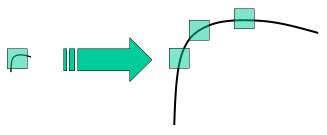

因此，在2004年，不列颠哥伦比亚大学的 D.Lowe 在他的论文中提出了一种新的算法：尺度不变特征变换（SIFT），《Distinctive Image Features from Scale-Invariant Keypoints》^2，这个算法提取关键点并计算其描述符。

SIFT算法主要涉及四个步骤。 我们会一一看到他们。

尺度空间极值检测

从上图中可以看出，我们不能用同一个窗口来检测不同尺度的关键点。 小的边角也许可以。 但要检测更大的边角，我们需要更大的窗口。

为此，需要使用缩放空间过滤。 这个过程中会寻找图片的不同\sigmaσ值的高斯拉普拉斯算子。 LoG作为一个斑点检测器，它可以检测由于$\sigma$中的变化而产生的各种大小的斑点。 简而言之，$\sigma$在此充当了一个缩放参数。 例如，在上面的图像中，低$\sigma$的高斯核为小边角赋值较高，而高$\sigma$的高斯核适合较大的角。 所以，我们可以找到跨越尺度和空间的局部最大值，它给出了一个$(x,y,\sigma)$值的列表，这意味着在$(x,y)$处有一个潜在比例为$\sigma$的关键点。

但是LoG性能开销比较大，所以SIFT算法使用LoG的近似：高斯滤波器的差值。 高斯滤波器差值就是高斯模糊过的有两个不同$\sigma$的同一幅图片的差值，设这两个$\sigma$值为$\sigma$和$k\sigma$。这个过程对每组不同的图像金字塔中的“octave”执行。

下面的图像展示了它的过程：

像Harris这样的角点检测器。它们是旋转不变的，这意味着，即使图像旋转了，我们也可以找到相同的角点。 这是显而易见的，因为边角在图像旋转后也是边角。 但是缩放呢？ 如果图像缩放，边角可能不再是一个边角。 例如，请看下面的简单图片。 放大后，小窗口内的图像中一个原先是边角的地方现在看起来是平滑的。 所以Harris角点检测不是比例不变的。

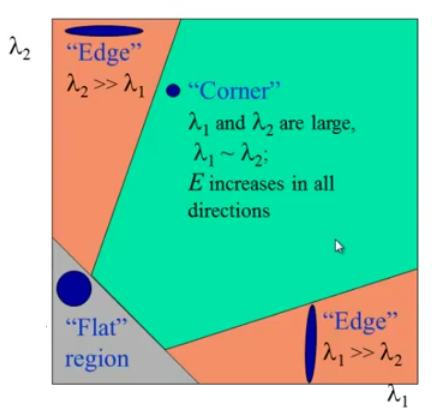

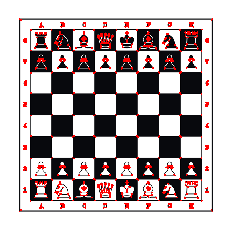

In [4]:
img = cv2.imread('C:/Users/hichens/Desktop/CV_code/images/board.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
# 结果被膨胀来显示出边缘，这不重要
dst = cv2.dilate(dst,None)
# 取图像超过一个最优化的阈值的部分，阈值根据图像会有所不同
img[dst>0.01*dst.max()]=[255, 0, 0] # 红色显示
plt.imshow(img, cmap="gray"), plt.axis("off")
plt.show()

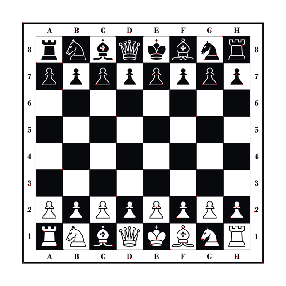

In [11]:
img = cv2.imread('C:/Users/hichens/Desktop/CV_code/images/board.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# 寻找Harris角点
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)
# 寻找质心
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
# 定义停止标准并改进角点
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
# 把它们画出来
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[255, 0, 0] 
img[res[:,3],res[:,2]] = [255, 0, 0] 

plt.figure(figsize=(10, 5))
plt.imshow(img, cmap="gray"), plt.axis("off")
plt.show()

# Shi-Tomasi 角点检测 & 适合用来跟踪的特征

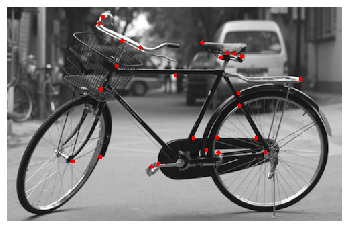

In [12]:
img = cv2.imread('C:/Users/hichens/Desktop/CV_code/images/bicycle.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),3,255,-1)
plt.imshow(img, cmap="gray"), plt.axis("off")
plt.show()

# SIFT（尺度不变特征转换）

# SURF

# 角点检测的Fast算法

Threshold: 10
nonmaxSuppression:True
neighborhood: 2
Total Keypoints with nonmaxSuppression: 1595
Total Keypoints without nonmaxSuppression: 10291


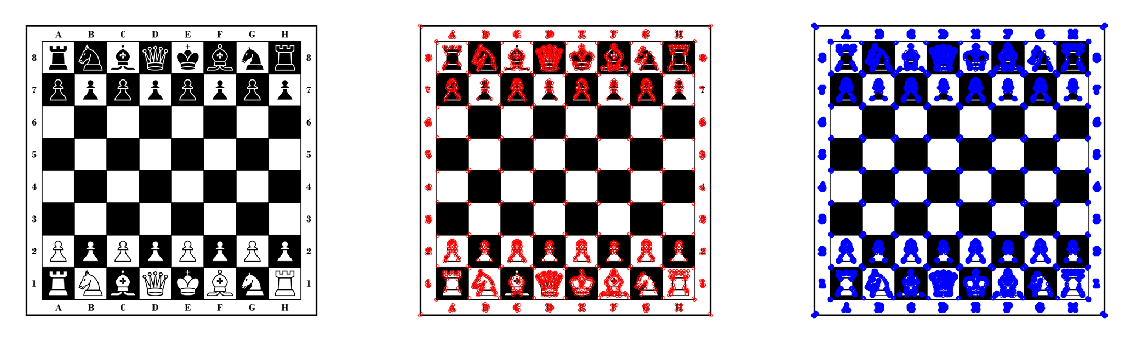

In [13]:
img = cv2.imread('C:/Users/hichens/Desktop/CV_code/images/board.png', 0)
plt.figure(figsize=(20, 8))
plt.subplot(131), plt.imshow(img, cmap="gray"), plt.axis("off")
# 用默认值初始化FAST检测器对象
fast = cv2.FastFeatureDetector_create()
# 查找并画出关键点
kp = fast.detect(img,None)

img2 = cv2.drawKeypoints(img, kp, None, color=(255,0,0))
# 输出所有默认参数
print( "Threshold: {}".format(fast.getThreshold()) )
print( "nonmaxSuppression:{}".format(fast.getNonmaxSuppression()) )
print( "neighborhood: {}".format(fast.getType()) )
print( "Total Keypoints with nonmaxSuppression: {}".format(len(kp)) )
plt.subplot(132), plt.imshow(img2, cmap="gray"), plt.axis("off")
# 禁用非最大抑制
fast.setNonmaxSuppression(0)
kp = fast.detect(img,None)
print( "Total Keypoints without nonmaxSuppression: {}".format(len(kp)) )
img3 = cv2.drawKeypoints(img, kp, None, color=(0, 0, 255))

plt.subplot(133), plt.imshow(img3, cmap="gray"), plt.axis("off")
plt.show()

# BRIEF特征点描述算法

In [6]:
img = cv2.imread('C:/Users/hichens/Desktop/CV_code/images/empire.jpg', 0)
# 初始化Star检测器
star = cv2.xfeatures2d.StarDetector_create()
# 初始化BRIEF提取器
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
# 用STAR找到关键点
kp = star.detect(img,None)
# 计算出BRIEF描述符
kp, des = brief.compute(img, kp)
print( brief.descriptorSize() )
print( des.shape )

32
(501, 32)


# ORB特征描述符(Oriented FAST and Rotated BRIEF)

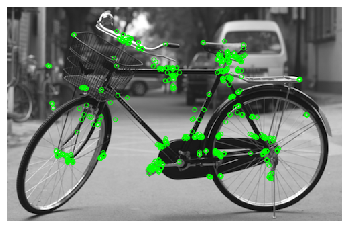

In [14]:
img = cv2.imread('C:/Users/hichens/Desktop/CV_code/images/bicycle.png', 0)
orb = cv2.ORB_create()
# 用ORB查找关键点
kp = orb.detect(img,None)
# 用ORB计算描述子
kp, des = orb.compute(img, kp)
# 只绘制关键点位置，不绘制大小和方向
img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2, cmap="gray"), plt.axis("off")
plt.show()

# 特征匹配

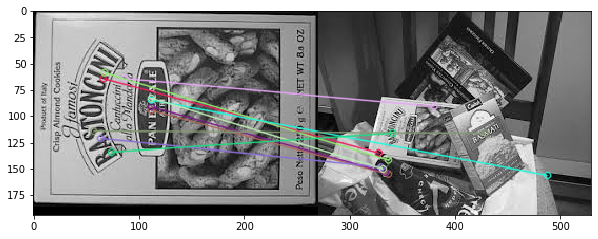

In [8]:
'''暴力匹配'''
img1 = cv2.imread('C:/Users/hichens/Desktop/CV_code/images/book.jpg',0)          # queryImage
img2 = cv2.imread('C:/Users/hichens/Desktop/CV_code/images/books.jpg',0) # trainImage
# 初始化ORB检测器
orb = cv2.ORB_create()
# 用ORB寻找关键点和描述符
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# 创建BFMatcher对象
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# 匹配描述符
matches = bf.match(des1,des2)
# 按照距离排序
matches = sorted(matches, key = lambda x:x.distance)
# 画出前10个匹配
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10], img3, flags=10 )
plt.figure(figsize=(10, 5))
plt.imshow(img3)
plt.show()

In [14]:
import cv2
from matplotlib import pyplot as plt

# 首先加载两幅图（查询图像和训练图像）
queryImage = cv2.imread('C:/Users/hichens/Desktop/CV_code/images/book.jpg',0) 
trainingImage = cv2.imread('C:/Users/hichens/Desktop/CV_code/images/books.jpg',0)

# 创建 SIFT 和 detect / compute
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(queryImage, None)
kp2, des2 = sift.detectAndCompute(trainingImage, None)

# FLANN 匹配参数
FLANN_INDEX_KDTREE = 0
indexParams = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
searchParams = dict(checks=50) #or pass empty dictionary

flann = cv2.FlannBasedMatcher(indexParams, searchParams)

matches = flann.knnMatch(des1, des2, k=2)

# prepare an empty mask to draw good matches
matchesMask = [[0, 0] for i in range(len(matches))]

# David G. Lowe's ratio test,populate the mask
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i] = [1, 0]

drawParams = dict(
    matchColor=(255, 0, 0),
    singlePointColor=(255.0, 0),
    matchesMask=matchesMask,
    flags=0
    )

resultImage = cv2.drawMatchesKnn(queryImage, kp1, trainingImage, kp2, matches, None, **drawParams)

plt.imshow(resultImage)
plt.show()

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv_contrib\modules\xfeatures2d\src\sift.cpp:1210: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SIFT::create'


# 图像显著性检测算法—HC/RC/LC/FT

## 基于谱残差法的显著性检测

In [ ]:
def visual_saliency_detection(mat):
    # 傅里叶变换 -> 拆分为实部，虚部 -> 振幅
    fourier = cv2.dft(np.float32(mat), flags=cv2.DFT_COMPLEX_OUTPUT)
    re = fourier[:, :, 0]
    im = fourier[:, :, 1]
    base = cv2.magnitude(re, im)

    # 对数谱 -> 平滑曲线 -> 显著性余谱
    LogAmplitude = cv2.log(base)
    blur = cv2.blur(LogAmplitude, (3, 3))
    residual = LogAmplitude - blur

    # 指数还原对数谱
    residual = cv2.exp(residual)

    # 求原频域上实虚的夹角, 利用夹角还原实虚
    Sine = im / base
    Cosine = re / base
    tmp1_re = residual * Cosine
    tmp2_im = residual * Sine

    # 傅里叶逆变换
    ifourier = cv2.merge((tmp1_re, tmp2_im))
    img_idf = cv2.idft(ifourier)
    img_idf = cv2.magnitude(img_idf[:, :, 0], img_idf[:, :, 1])
    img_idf = cv2.GaussianBlur(img_idf**2, (7, 7), 0)

    # 优化结果显示
    min_v, max_v, _, _ = cv2.minMaxLoc(img_idf**2)
    _, thre = cv2.threshold(img_idf, 0, 255, cv2.THRESH_TOZERO)
    img_idf = thre * (255 / max_v-min_v)
    return img_idf


img = cv2.imread('C:/Users/hichens/Desktop/CV_code/images/lena.png', 0)
res = visual_saliency_detection(img)

plt.figure(figsize=(20, 8))
plt.subplot(121), plt.imshow(img, cmap="gray"), plt.axis("off")
plt.subplot(122), plt.imshow(res, cmap="gray"), plt.axis("off")
plt.show()

## 基于全局对比度图像显著性检测（LC）

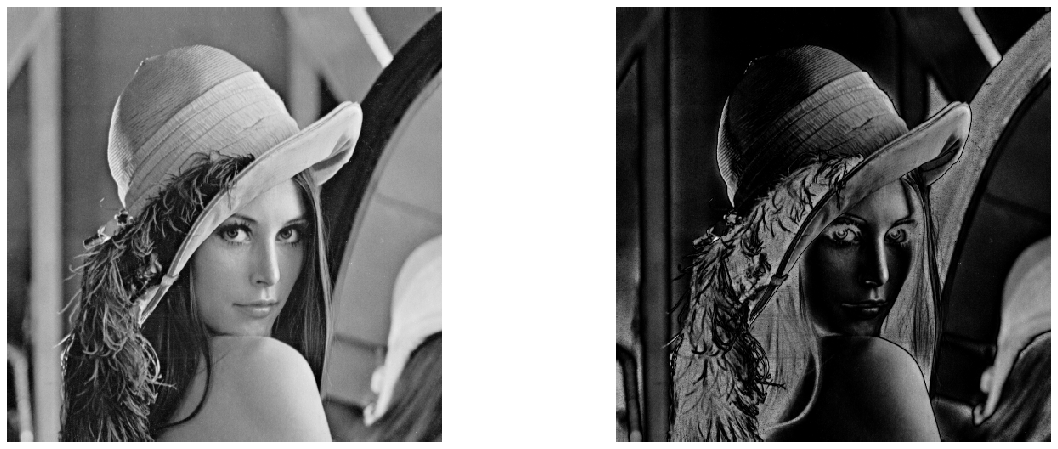

In [24]:
def diag_sym_matrix(k=256):
    base_matrix = np.zeros((k,k))
    base_line = np.array(range(k))
    base_matrix[0] = base_line
    for i in range(1,k):
        base_matrix[i] = np.roll(base_line,i)
    base_matrix_triu = np.triu(base_matrix)
    return base_matrix_triu + base_matrix_triu.T

def cal_dist(hist):
    Diag_sym = diag_sym_matrix(k=256)
    hist_reshape = hist.reshape(1,-1)
    hist_reshape = np.tile(hist_reshape, (256, 1))
    return np.sum(Diag_sym*hist_reshape,axis=1)

def LC(image_gray):
    image_height,image_width = image_gray.shape[:2]
    hist_array = cv2.calcHist([image_gray], [0], None, [256], [0.0, 256.0])
    gray_dist = cal_dist(hist_array)

    image_gray_value = image_gray.reshape(1,-1)[0]
    image_gray_copy = [(lambda x: gray_dist[x]) (x)  for x in image_gray_value]
    image_gray_copy = np.array(image_gray_copy).reshape(image_height,image_width)
    image_gray_copy = (image_gray_copy-np.min(image_gray_copy))/(np.max(image_gray_copy)-np.min(image_gray_copy))
    return image_gray_copy



image_gray = cv2.imread('C:/Users/hichens/Desktop/CV_code/images/lena.png', 0)
saliency_image = LC(image_gray)

plt.figure(figsize=(20, 8))
plt.subplot(121), plt.imshow(image_gray, cmap="gray"), plt.axis("off")
plt.subplot(122), plt.imshow(saliency_image, cmap="gray"), plt.axis("off")
plt.show()

## 基于区域的对比度方法(region-based contrast 简称RC)

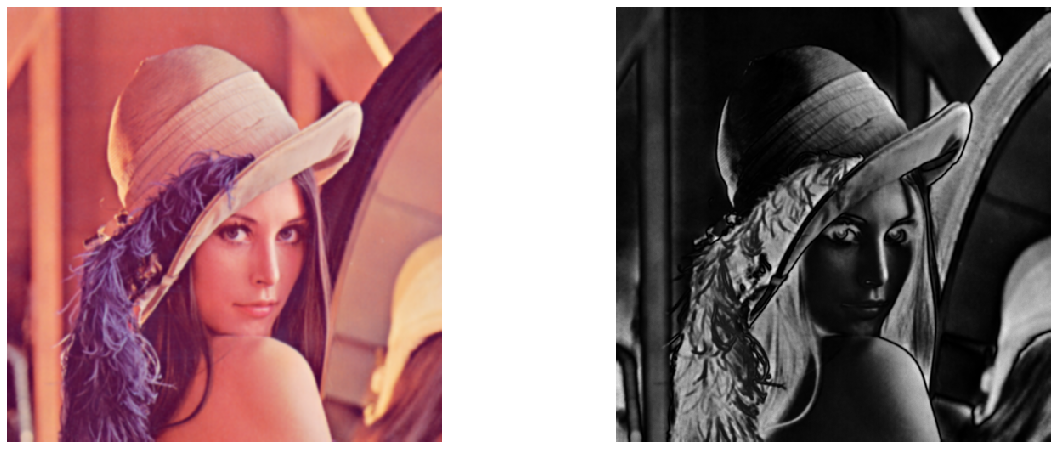

In [25]:




img = cv2.imread('C:/Users/hichens/Desktop/CV_code/images/lena.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.GaussianBlur(img,(5,5), 0)
gray_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

l_mean = np.mean(gray_lab[:,:,0])
a_mean = np.mean(gray_lab[:,:,1])
b_mean = np.mean(gray_lab[:,:,2])
lab = np.square(gray_lab- np.array([l_mean, a_mean, b_mean]))
lab = np.sum(lab,axis=2)
lab = lab/np.max(lab)

plt.figure(figsize=(20, 8))
plt.subplot(121), plt.imshow(img, cmap="gray"), plt.axis("off")
plt.subplot(122), plt.imshow(lab, cmap="gray"), plt.axis("off")
plt.show()

## 显著性检测 AC

In [ ]:
'''cost a lot of time'''
def AC(imagelab):
    height, width = imagelab.shape[:2]
    medical = min(height, width)
    offset1 = int(medical / 2)
    offset2 = int(medical / 4)
    offset3 = int(medical / 8)
    l = imagelab[:, :, 0]
    a = imagelab[:, :, 1]
    b = imagelab[:, :, 2]

    sm = np.zeros((height, width),dtype=np.float32)

    for j in range(height):
        y11 = max(1, j - offset1)
        y12 = min(j + offset1,height)

        y21 = max(1, j - offset2)
        y22 = min(j + offset2, height)

        y31 = max(1, j - offset3)
        y32 = min(j + offset3, height)
        for k in range(width):
            x11 = max(1, k - offset1)
            x12 = min(k + offset1, width)
            x21 = max(1, k - offset2)
            x22 = min(k + offset2, width)
            x31 = max(1, k - offset3)
            x32 = min(k + offset3, width)
            lm1 = np.mean(l[y11:y12, x11: x12])
            am1 = np.mean(a[y11:y12, x11: x12])
            bm1 = np.mean(b[y11:y12, x11: x12])

            lm2 = np.mean(l[y21:y22, x21: x22])
            am2 = np.mean(a[y21:y22, x21: x22])
            bm2 = np.mean(b[y21:y22, x21: x22])
            lm3 = np.mean(l[y31:y32, x31: x32])
            am3 = np.mean(a[y31:y32, x31: x32])
            bm3 = np.mean(b[y31:y32, x31: x32])

            cv1 = (l[j, k] - lm1)**2 + (a[j, k] - am1)**2 + (b[j, k] - bm1)**2
            cv2 = (l[j, k] - lm2)**2 + (a[j, k] - am2)**2 + (b[j, k] - bm2)**2
            cv3 = (l[j, k] - lm3)**2 + (a[j, k] - am3)**2 + (b[j, k] - bm3)**2
            sm[j, k] = cv1 + cv2 + cv3
    return sm


image_gray = cv2.imread('C:/Users/hichens/Desktop/CV_code/images/lena.png')
imagelab = cv2.cvtColor(image_gray,cv2.COLOR_RGB2Lab)
result = AC(imagelab)

plt.figure(figsize=(20, 8))
plt.subplot(121), plt.imshow(image_gray, cmap="gray"), plt.axis("off")
plt.subplot(122), plt.imshow(result, cmap="gray"), plt.axis("off")
plt.show()